In [20]:
%matplotlib inline
import numpy as np
import matplotlib
import os
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from scipy.stats import stats
sns.set(style="whitegrid", color_codes=True)
plt.rcParams['figure.figsize'] = (12, 12)

In [21]:
gndvi_img_dir = "/home/dat/Workspace/Thesis/lettuce_detector/data/raw/2017-10-27_GNDVI_BGNIR/lettuce"
csv_file = "/home/dat/Workspace/Thesis/data/Spreadsheet/Lettuce/2017-10-27.csv"

### Distribution of GNDVI values

In [25]:
lettuce_gndvi = {}
for fname in os.listdir(gndvi_img_dir):
    img = np.asarray(Image.open(os.path.join(gndvi_img_dir, fname)).convert("L"))
    gndvi = (img - 128) / 128
    lettuce_gndvi[fname.split(".")[0]] = np.average(gndvi)

In [26]:
gndvi_values = list(lettuce_gndvi.values())

print("Average: %.4f" % np.average(gndvi_values))
print("Std Dev: %.4f" % np.std(gndvi_values))

Average: 0.3829
Std Dev: 0.0296


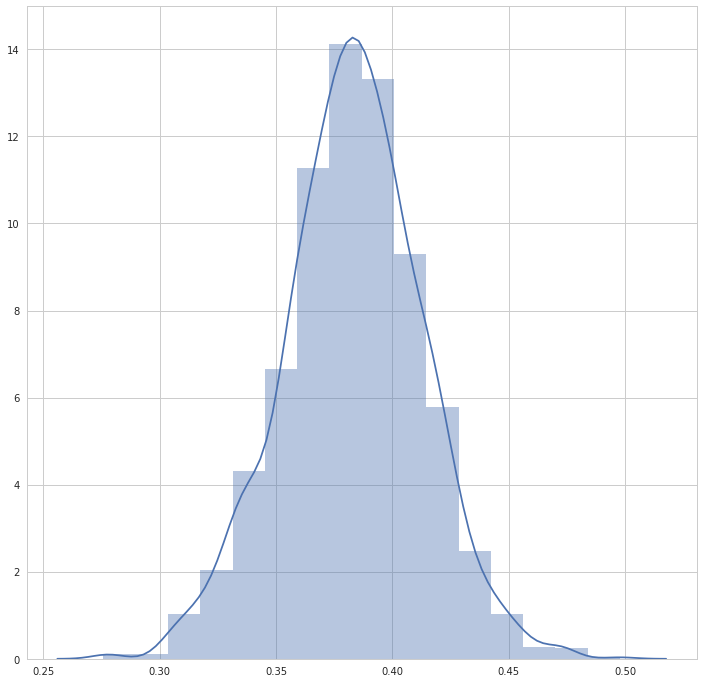

In [27]:
sns.distplot(gndvi_values, bins=16)

In [28]:
nitrogen_gndvi = {}
irrigation_gndvi = {}
for treatment in [100, 50, 25, 0]:
    nitrogen_gndvi[treatment] = []
    irrigation_gndvi[treatment] = []
    for k, v in lettuce_gndvi.items():
        if "N{}".format(treatment) in k:
            nitrogen_gndvi[treatment].append(v)
        if "IR{}".format(treatment) in k:
            irrigation_gndvi[treatment].append(v)

In [29]:
nitrogen_avg = {k:np.average(values) for k, values in nitrogen_gndvi.items()}
nitrogen_stddev = {k:np.std(values) for k, values in nitrogen_gndvi.items()}

print(nitrogen_avg)
print(nitrogen_stddev)

{100: 0.37779596899042378, 50: 0.38348244240463603, 25: 0.38870417747427632, 0: 0.38183645456557125}
{100: 0.02851791848826531, 50: 0.02893528261202603, 25: 0.030276038960039331, 0: 0.029580106629251455}


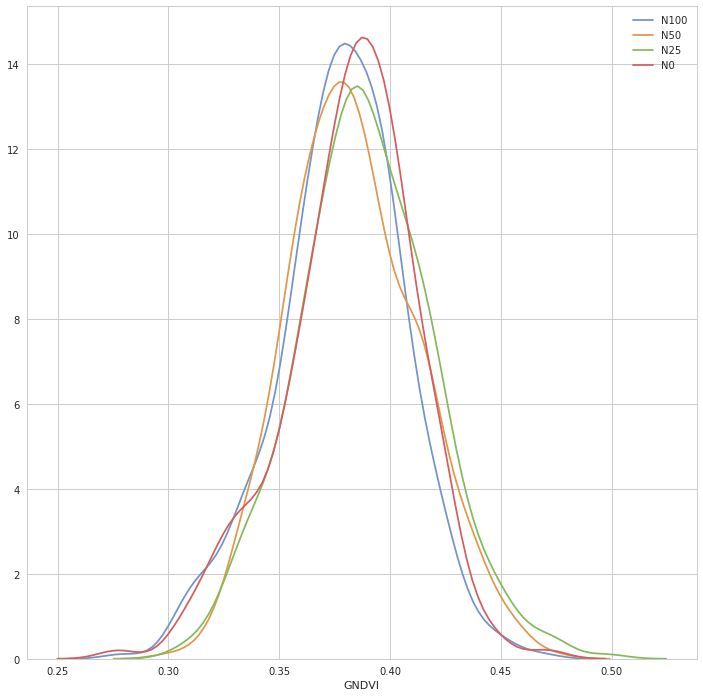

In [30]:
sns.distplot(nitrogen_gndvi[100], bins=16, hist=False, color="#7293CB", label="N100")
sns.distplot(nitrogen_gndvi[50],  bins=16, hist=False, color="#E1974C", label="N50")
sns.distplot(nitrogen_gndvi[25],  bins=16, hist=False, color="#84BA5B", label="N25")
sns.distplot(nitrogen_gndvi[0],   bins=16, hist=False, color="#D35E60", label="N0", axlabel="GNDVI")

In [31]:
irrigation_avg = {k:np.average(values) for k, values in irrigation_gndvi.items()}
irrigation_stddev = {k:np.std(values) for k, values in irrigation_gndvi.items()}

print(irrigation_avg)
print(irrigation_stddev)

{100: 0.39206729895792575, 50: 0.38284525251700352, 25: 0.37822286782702647, 0: 0.37874635796375972}
{100: 0.033463006943010305, 50: 0.027289444587951732, 25: 0.026506250345253186, 0: 0.028639802410913833}


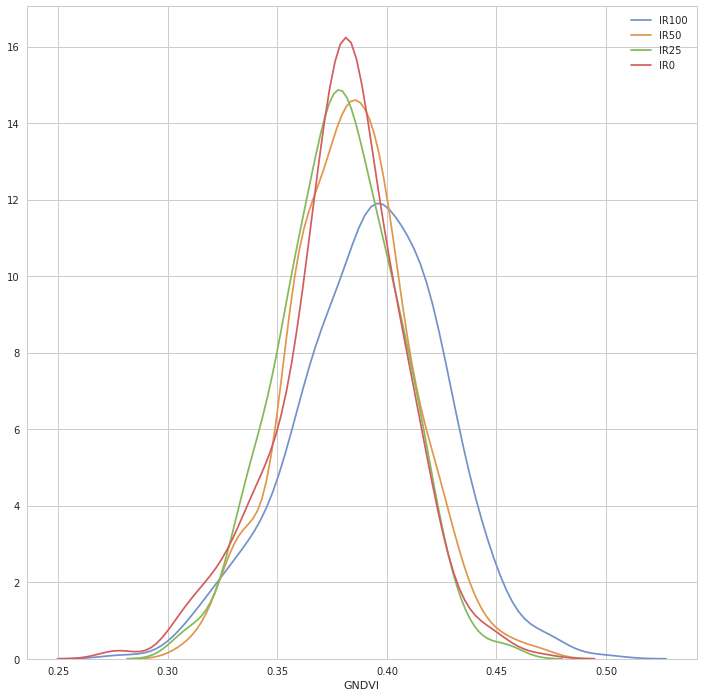

In [32]:
sns.distplot(irrigation_gndvi[100], bins=16, hist=False, color="#7293CB", label="IR100")
sns.distplot(irrigation_gndvi[50],  bins=16, hist=False, color="#E1974C", label="IR50")
sns.distplot(irrigation_gndvi[25],  bins=16, hist=False, color="#84BA5B", label="IR25")
sns.distplot(irrigation_gndvi[0],   bins=16, hist=False, color="#D35E60", label="IR0", axlabel="GNDVI")

### Analyze ground data

In [33]:
df = pd.read_csv(csv_file)
df.head()

,Nitrogen,Irrigation,Replication,Plant Number,Chlorophyll,NDVI,WP,Average Height,Average Leaf Count
0,0,0,1,104,48.9,0.805878,-4.80,6,7
1,0,0,1,113,44.4,0.815393,NaN,6,7
2,0,0,2,104,48.8,0.839747,-4.24,4,6
3,0,0,2,113,53.5,0.819832,NaN,4,6
4,0,0,3,104,51.9,0.812323,-4.82,7,6


In [34]:
pre_df = {
    "Nitrogen": [],
    "Irrigation": [],
    "Replication": [],
    "Plant Number": [],
    "uav_gndvi": [],
}
for k, v in lettuce_gndvi.items():
    nitrogen = int(re.search("N(.*)IR.*", k).group(1))
    irrigation = int(re.search(".*IR(.*)Rep.*", k).group(1))
    replication = int(re.search(".*Rep(.*)_", k).group(1))
    number = int(re.search(".*_(.*)", k).group(1))
    
    if number == 104 or number == 113:
        pre_df["Nitrogen"].append(nitrogen)
        pre_df["Irrigation"].append(irrigation)
        pre_df["Replication"].append(replication)
        pre_df["Plant Number"].append(number)
        pre_df["uav_gndvi"].append(v)

gndvi_df = pd.DataFrame(data=pre_df)

In [35]:
merged_df = pd.merge(df, gndvi_df, on=["Nitrogen", "Irrigation", "Replication", "Plant Number"])
merged_df.head()

,Nitrogen,Irrigation,Replication,Plant Number,Chlorophyll,NDVI,WP,Average Height,Average Leaf Count,uav_gndvi
0,0,0,1,104,48.9,0.805878,-4.80,6,7,0.390789
1,0,0,1,113,44.4,0.815393,NaN,6,7,0.410291
2,0,0,2,104,48.8,0.839747,-4.24,4,6,0.305170
3,0,0,2,113,53.5,0.819832,NaN,4,6,0.355128
4,0,0,3,104,51.9,0.812323,-4.82,7,6,0.387968


In [39]:
print("UAV GNDVI & Chlorophyll:", stats.pearsonr(merged_df["uav_gndvi"], merged_df["Chlorophyll"])[0])
print("UAV GNDVI & NDVI:", stats.pearsonr(merged_df["uav_gndvi"], merged_df["NDVI"])[0])
print("UAV GNDVI & Height:", stats.pearsonr(merged_df["uav_gndvi"], merged_df["Average Height"])[0])
print("UAV GNDVI & Leaf Count:", stats.pearsonr(merged_df["uav_gndvi"], merged_df["Average Leaf Count"])[0])
print("UAV GNDVI & WP:", stats.pearsonr(merged_df.dropna()["uav_gndvi"], merged_df.dropna()["WP"])[0])

UAV GNDVI & Chlorophyll: -0.0577505123558
UAV GNDVI & NDVI: -0.01208993996
UAV GNDVI & Height: 0.172900192126
UAV GNDVI & Leaf Count: 0.160864023127
UAV GNDVI & WP: -0.0546176532515


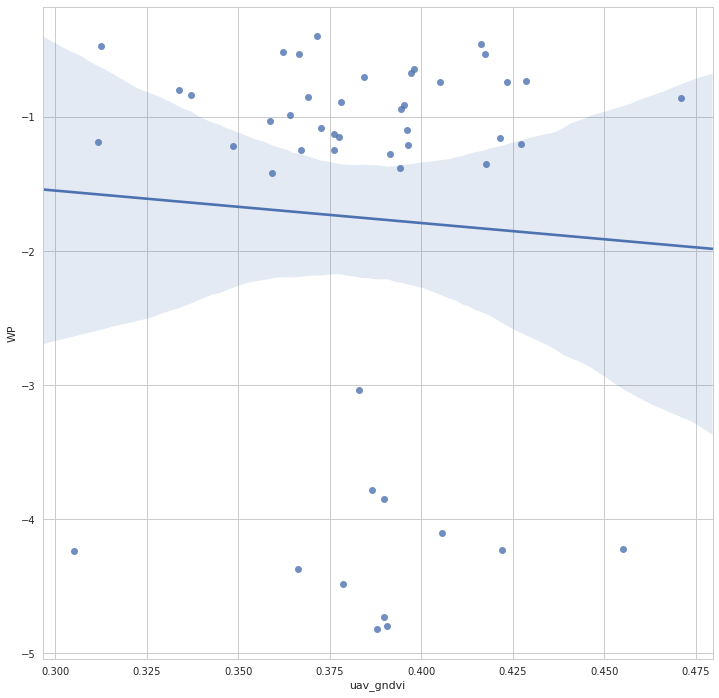

In [40]:
sns.regplot(x=merged_df["uav_gndvi"], y=merged_df["WP"])